In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [3]:
os.chdir('../')

In [4]:
import make_dictionaries

question_dictionary = make_dictionaries.questions
debiased_data = Table.read('../fits/full_sample_full_run.fits')
print('Loaded galaxy data...')

Loaded galaxy data...


In [5]:
def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,normalised_values=True,dataset='w13'):
    '''For a given question, get thresholded data'''
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']

    if normalised_values == True:
        suffix = '_debiased_rh'#_normalised'
    else:
        suffix = '_debiased_rh_normalised'
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
        
        select = np.ones(len(data_reduced)) == 1
    
    return data_reduced,select

In [6]:
in_volume_limit = debiased_data['in_volume_limit'] == True
vl_data = debiased_data[in_volume_limit]

In [16]:
question_order = ['t01_smooth_or_features'
                  ,'t02_edgeon'
                  ,'t03_bar'
                  ,'t04_spiral'
                  ,'t05_bulge_prominence'
                  #,'t06_odd'
                  ,'t07_rounded'
                  #,'t08_odd_feature'
                  ,'t09_bulge_shape'
                  ,'t10_arms_winding'
                  ,'t11_arms_number']

In [17]:
def plot_histograms(question_dictionary,data,questions,N_bins=5,logy=True):
    
    high_z = (data['REDSHIFT_1'] > 0.08) & (data['REDSHIFT_1'] <= 0.085)
    low_z = (data['REDSHIFT_1'] > 0.03) & (data['REDSHIFT_1'] <= 0.035)
    hist_bins = np.linspace(0,1,N_bins+1)

    N_ans = np.zeros(len(questions))
    for i,question in enumerate(questions):
        N_ans[i] = len(question_dictionary[question]['answers'])
    N_x = np.max(N_ans).astype(int)
    N_y = len(questions)
    fig,axarr = plt.subplots(N_y,N_x,figsize=(20,N_y/N_x*20),sharex=True)
    
    for y,question in enumerate(questions):
        
        s_data,select = reduce_sample(data,question_dictionary,question,dataset=None)
        
        N_qa = N_ans[y].astype(int)
        for ax in axarr[y,N_qa:]:
            fig.delaxes(ax)
            
        answers = question_dictionary[question]['answers']
        answerlabels = question_dictionary[question]['answerlabels']
        axarr[y,0].set_ylabel(question_dictionary[question]['questionlabel'])
        
        for x,answer in enumerate(answers):
            
            ref = data[question + '_' + answer + '_weighted_fraction'][(low_z) & (select)]
            raw = data[question + '_' + answer + '_weighted_fraction'][(high_z) & (select)]
            w13 = data[question + '_' + answer + '_debiased'][(high_z) & (select)]
            h16 = data[question + '_' + answer + '_debiased_rh'][(high_z) & (select)]
            
            _ = axarr[y,x].hist(ref,bins=hist_bins,normed=True,
                                histtype='stepfilled',linewidth=0,color='k',alpha=0.3)
            _ = axarr[y,x].hist(raw,bins=hist_bins,normed=True,
                                histtype='step',linewidth=4,color='k',linestyle='solid')
            _ = axarr[y,x].hist(w13,bins=hist_bins,normed=True,
                                histtype='step',linewidth=5,color='b',linestyle='dotted')
            _ = axarr[y,x].hist(h16,bins=hist_bins,normed=True,
                                histtype='step',linewidth=4,color='r',linestyle='dashed')
            
            axarr[y,x].set_title(answerlabels[x])
            
            if logy == True:
                axarr[y,x].set_yscale('log')
        
            axarr[y,x].set_yticks([])
            
    fig.text(0.5, 0.1,'$p$' , ha='center',size=30)
    fig.text(0.04, 0.5, '$\log(f)$', va='center', rotation='vertical',size=30)
    
    return None

# Histograms of all questions

Grey underplotted histogram = low-z reference <br>
Black = raw <br>
Blue = Willett et al. (2013) <br>
Red = our debiasing <br>

Primary question, so all 62220 galaxies used.
35279/62220 galaxies with p>0.5 and N>=5.
28840/62220 galaxies with p>0.5 and N>=5.
28840/62220 galaxies with p>0.5 and N>=5.
28840/62220 galaxies with p>0.5 and N>=5.
22255/62220 galaxies with p>0.5 and N>=5.
28840/62220 galaxies with p>0.5 and N>=5.
21029/62220 galaxies with p>0.5 and N>=5.
21029/62220 galaxies with p>0.5 and N>=5.


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater


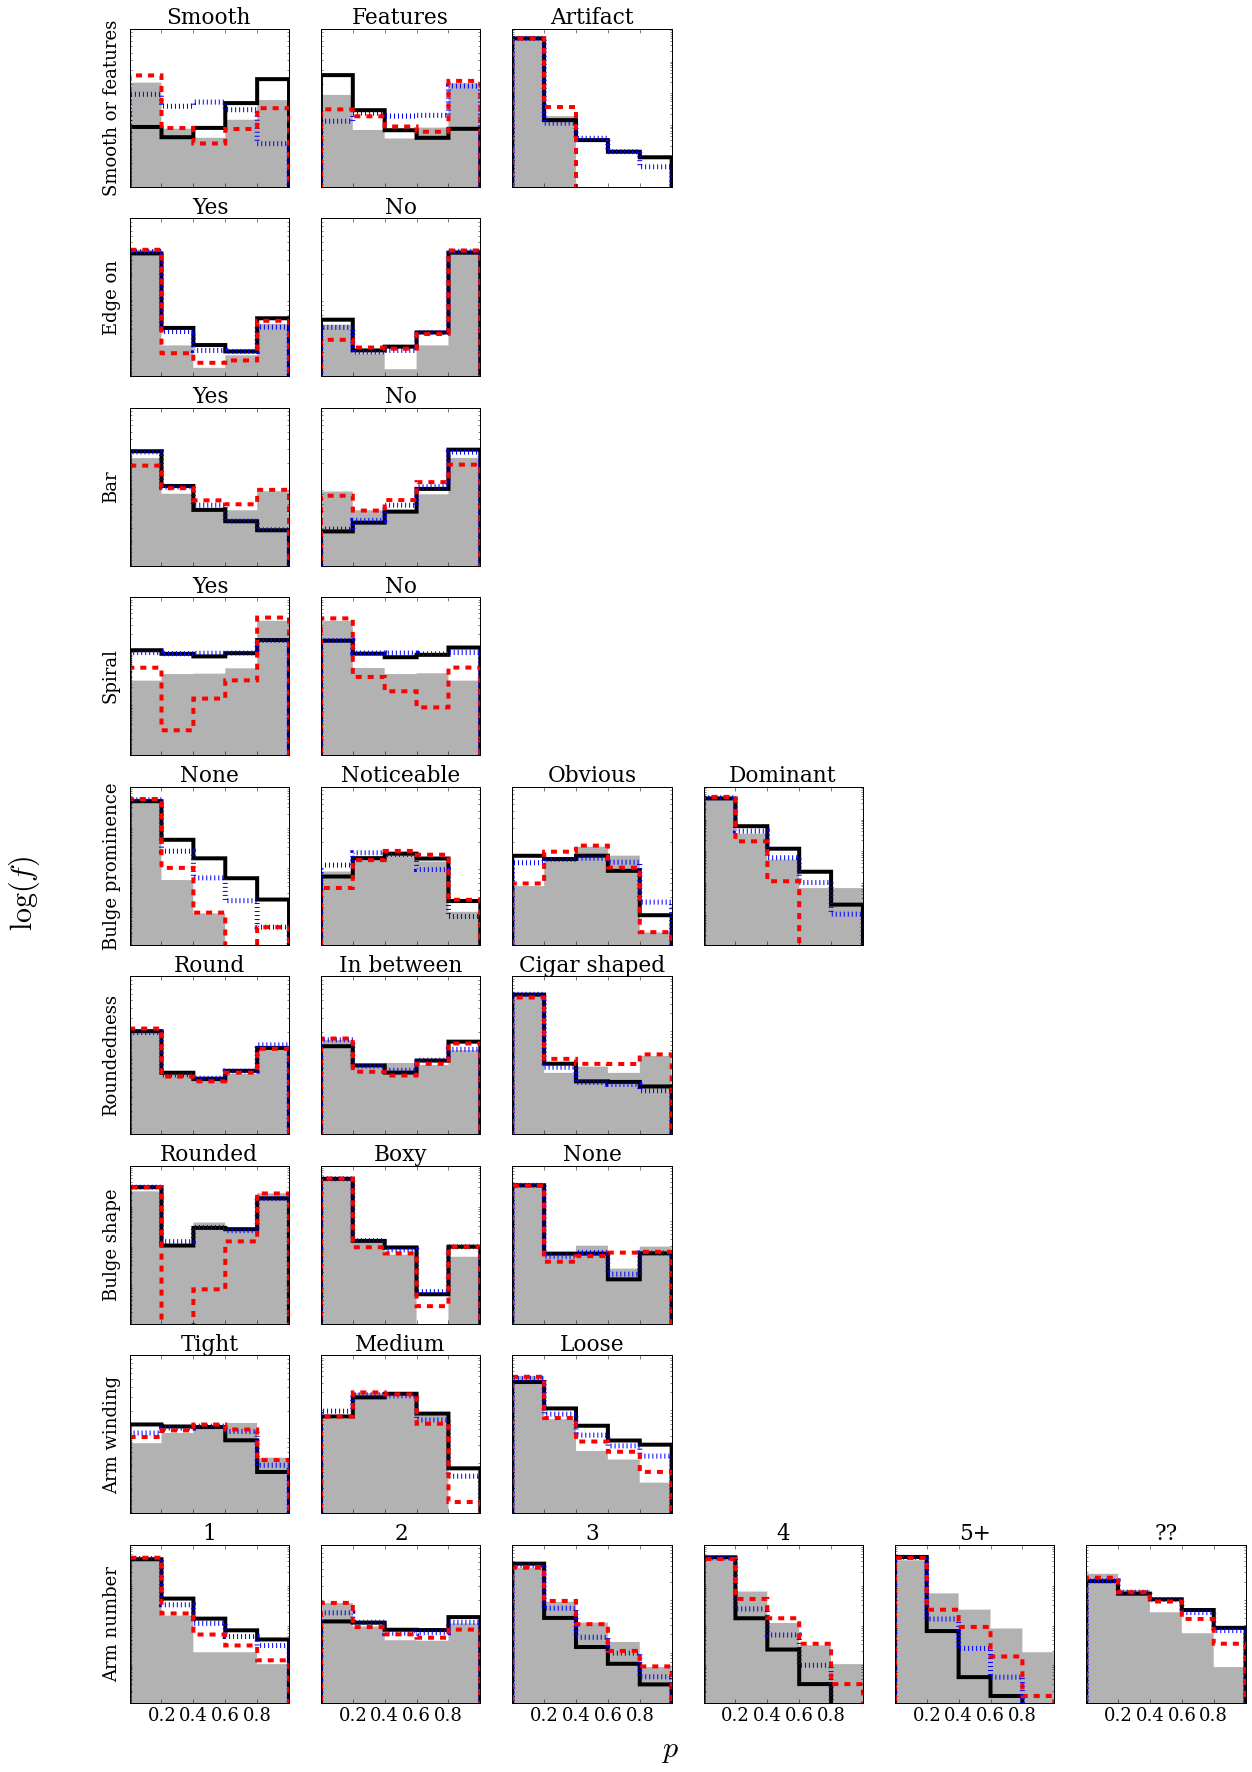

In [20]:
plot_histograms(question_dictionary,vl_data,question_order)
#plt.savefig('figures/all_histograms.pdf')